In [42]:
from GRLT_analysis.data_loader import data_loader
import pandas as pd
from functools import reduce

In [43]:
datapaths = ["conditions_gastrointestinal.csv", "dog_profile.csv", "environment_conditions.csv", "environment_spend_time_location.csv", "exam_physical.csv", "poison_exposure.csv", "study_endpoints.csv"]

In [44]:
dfs = []
for index, datapath in enumerate(datapaths):
    print("Adding: ", datapath)
    full_path = "data/" + datapath
    temp = data_loader(file_path=full_path)
    temp.download_csv()
    temp.identify_type()
    temp.clean_junk()
    temp.select_year("all")
    if index == len(datapaths) - 1:
        temp.age_death_variable()
    dfs.append(temp.file)

Adding:  conditions_gastrointestinal.csv
For context, there are 16.0 entries in this dataset per unique dog for the timeframe you have selected
Adding:  dog_profile.csv
For context, there are 1.0 entries in this dataset per unique dog for the timeframe you have selected
year in study is not an included variable in this dataset, this dataset is not valid to use for this function
Adding:  environment_conditions.csv
For context, there are 12.709592641261498 entries in this dataset per unique dog for the timeframe you have selected
Adding:  environment_spend_time_location.csv
day_outdoor_garage
day_outdoor_kennel
day_outdoor_fenced
day_outdoor_chain_or_lead
day_outdoor_other_percentage
day_outdoor_total_percentage
For context, there are 5.483902759526938 entries in this dataset per unique dog for the timeframe you have selected
Adding:  exam_physical.csv
For context, there are 6.889618922470434 entries in this dataset per unique dog for the timeframe you have selected
Adding:  poison_expos

In [45]:
def merge_avoiding_duplicates(left, right):
    cols_to_drop = [col for col in right.columns if col in left.columns and col != 'subject_id__I']
    right = right.drop(columns=cols_to_drop)
    return pd.merge(left, right, on='subject_id__I', how='left')

merged_df = reduce(merge_avoiding_duplicates, dfs)
merged_df

,subject_id__I,year_in_study__Q_x,index,year_in_study__Q_y,relationship_category__C,to_date__C,any__C,acid_reflux__C,acute_colitis__C,bacterial_overgrowth__C,...,mucous_membrane_cyanotic__C,year_in_study__Q,PoisonControlLastYear__Q,PoisonControlMoreThanTwice__Q,tier_of_confidence__Q,status__C,is_cause_of_death__C,is_recurrence__C,is_adjudicated__C,lifespan_days__Q
0,grls007MPNZZ,3.5,0,0,DOG,0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,grls00NB23WW,3.5,16,0,DOG,0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,1.0,final,1.0,0.0,1.0,2070 days
2,grls01C2L8RR,3.5,32,0,DOG,0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,1.0,final,1.0,0.0,1.0,3011 days
3,grls01LNL888,3.5,48,0,DOG,0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,grls01RDAKNN,3.5,64,0,DOG,0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,grlsZW6L5W33,3.5,48624,0,DOG,0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3202,grlsZY1Z1OSS,3.5,48640,0,DOG,0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,1.0,final,1.0,0.0,1.0,3103 days
3203,grlsZY5KYKXX,3.5,48656,0,DOG,0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,1.0,definitive,0.0,0.0,0.0,2617 days
3204,grlsZYI0K6LL,3.5,48672,0,DOG,0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [46]:
df_filtered = merged_df[merged_df['lifespan_days__Q'].notna()] # Only use entries with usable life-lengths
df_filtered = df_filtered.loc[:, df_filtered.nunique() > 1] # Remove any useless columns which snuck in

life_lengths = df_filtered['lifespan_days__Q'].dt.days.to_numpy()
life_lengths = life_lengths.astype(float)
# print(life_lengths)

In [47]:
df_filtered = df_filtered.select_dtypes(exclude=['object', 'string', 'datetime'])
data_array = df_filtered.values[:,1:-1]
data_array = data_array.astype(float)
# print(data_array)

Added feature 39: val MSE = 520083.42419, improvement = inf (total: [39])
Added feature 43: val MSE = 419302.68548, improvement = 100780.73872 (total: [39, 43])
Added feature 35: val MSE = 373111.11703, improvement = 46191.56845 (total: [39, 43, 35])
Added feature 11: val MSE = 344058.40553, improvement = 29052.71149 (total: [39, 43, 35, 11])
Added feature 21: val MSE = 321557.91833, improvement = 22500.48720 (total: [39, 43, 35, 11, 21])
Added feature 44: val MSE = 307386.67390, improvement = 14171.24442 (total: [39, 43, 35, 11, 21, 44])
Added feature 45: val MSE = 296397.07177, improvement = 10989.60213 (total: [39, 43, 35, 11, 21, 44, 45])
Added feature 37: val MSE = 284676.36508, improvement = 11720.70669 (total: [39, 43, 35, 11, 21, 44, 45, 37])
Added feature 27: val MSE = 278032.25619, improvement = 6644.10889 (total: [39, 43, 35, 11, 21, 44, 45, 37, 27])
Added feature 38: val MSE = 270189.84252, improvement = 7842.41367 (total: [39, 43, 35, 11, 21, 44, 45, 37, 27, 38])
Added fea

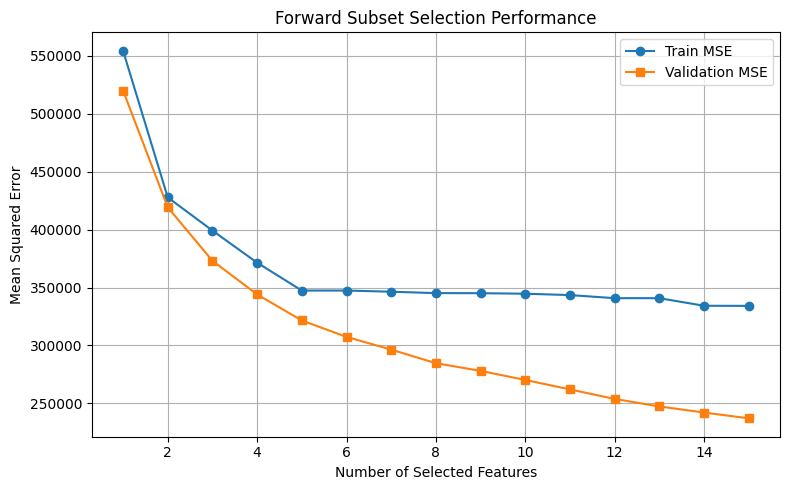

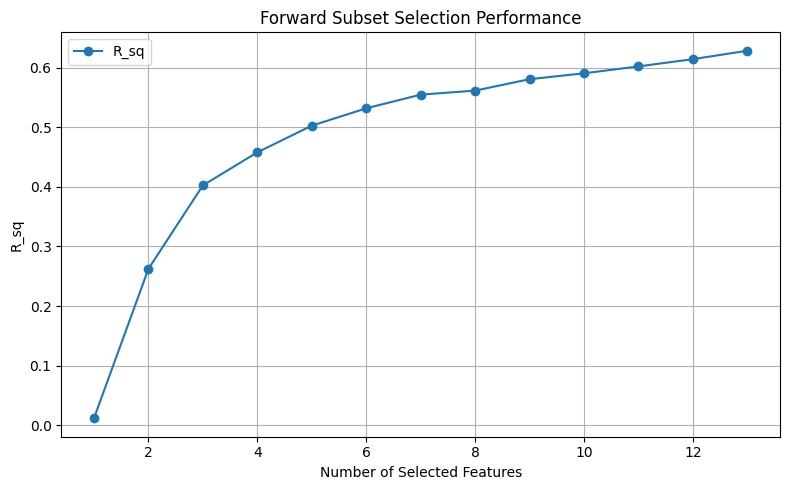

In [48]:
from GRLT_analysis.feature_selection import forward_subset_selection
from GRLT_analysis.feature_selection import lasso_feature_selection

selected_features, theta, preds, mse, r2 = forward_subset_selection(
    data_array, life_lengths, val_ratio=0.2, epsilon=1e-4, max_features=15)

In [37]:
column_names = df_filtered.columns[selected_features].tolist()
column_names

['tier_of_confidence__Q',
 'vomiting__C',
 'capillary_refill_not_evaluated__C',
 'any_treated_insects__C',
 'indoor_crate_flooring__Q',
 'bloat_without_torsion__C',
 'diarrhea__C',
 'furniture_type_other__Q',
 'is_cause_of_death__C',
 'chronic_colitis__C',
 'indoor_linoleum_flooring__Q',
 'is_euthanized__C',
 'indoor_other_flooring__Q',
 'furniture_type_upholstered__Q',
 'PoisonControlMoreThanTwice__Q']

In [54]:
for index, name in enumerate(column_names):
    print(index, "\tCategory: ", name, "\t\tCoeff: ", theta[index])

0 	Category:  tier_of_confidence__Q 		Coeff:  2961.563532259018
1 	Category:  vomiting__C 		Coeff:  -142.42570876006337
2 	Category:  capillary_refill_not_evaluated__C 		Coeff:  -271.7291565742598
3 	Category:  any_treated_insects__C 		Coeff:  -152.35564200046758
4 	Category:  indoor_crate_flooring__Q 		Coeff:  166.4776463312911
5 	Category:  bloat_without_torsion__C 		Coeff:  146.0002048161745
6 	Category:  diarrhea__C 		Coeff:  27.043501306048718
7 	Category:  furniture_type_other__Q 		Coeff:  -8.739388561126077
8 	Category:  is_cause_of_death__C 		Coeff:  6.751174880088442
9 	Category:  chronic_colitis__C 		Coeff:  -27.29820232924456
10 	Category:  indoor_linoleum_flooring__Q 		Coeff:  6.917342803086278
11 	Category:  is_euthanized__C 		Coeff:  46.63263736555563
12 	Category:  indoor_other_flooring__Q 		Coeff:  41.75717705580267
13 	Category:  furniture_type_upholstered__Q 		Coeff:  -29.022990884622182
14 	Category:  PoisonControlMoreThanTwice__Q 		Coeff:  -83.60397314073435


In [1]:
# Top explanatory variables:
# Tier of confidence -- confidence in fatal diagnosis (positive)
# Vomiting -- record of routine vomiting in gastrointestinal conditions (negative)
# Capillary Refill Not Evaluated -- did not evaluate blood flow in appointment (negative)
# Any Treated Insects -- home treated for insects (negative)

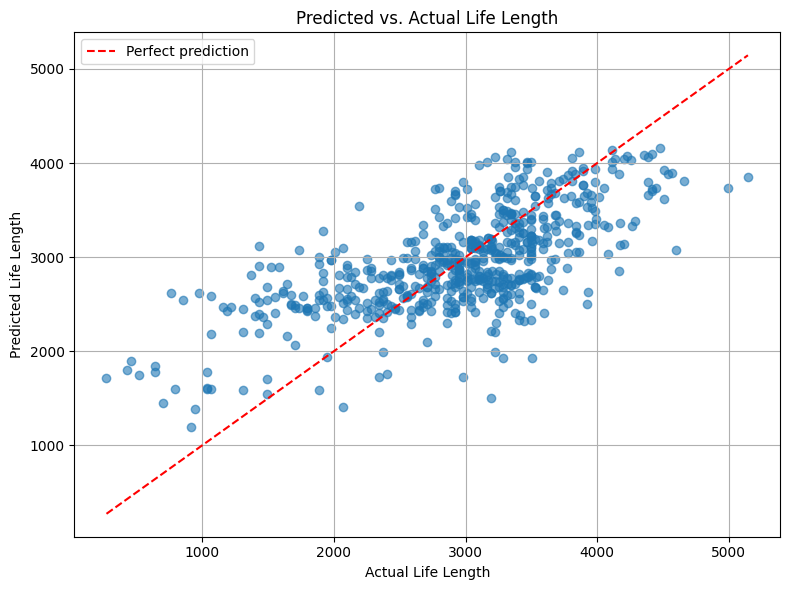

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(life_lengths, preds, alpha=0.6)
plt.plot([min(life_lengths), max(life_lengths)], [min(life_lengths), max(life_lengths)], color='red', linestyle='--', label='Perfect prediction')

plt.xlabel("Actual Life Length")
plt.ylabel("Predicted Life Length")
plt.title("Predicted vs. Actual Life Length")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
# Lasso selection
lasso_features, coefs, intercept, preds, alpha, val_mse, r_sq = lasso_feature_selection(
    data_array, life_lengths, val_ratio=0.2, alpha_min=1e-4, alpha_max=0.1, n_alphas=20
)

Lasso failed: Never found suitable features


TypeError: cannot unpack non-iterable NoneType object